In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, COLORMAPS
from collections import Counter
from matplotlib.lines import Line2D
from aging.organization.dataframes import load_male_long_df, load_female_long_df, DF_PATHS
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, median_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression

In [3]:
cmm = COLORMAPS.ont_male
cmf = COLORMAPS.ont_female
m_df = load_male_long_df(average_weeks=True, merge_size=False, merge_ages=True, df_path=DF_PATHS.usage_male).groupby(['age','mouse']).mean()
f_df = load_female_long_df(average_weeks=True, merge_size=False, filter_female=True, merge_ages=True, df_path=DF_PATHS.usage_female).groupby(['age','mouse']).mean()

In [4]:
# choose a model for decoder
clf = PLSRegression(n_components=5)
cv = LeaveOneOut()
#number of iterations for shuffle
it=100

In [5]:
format_plots()

In [6]:
#prepare data
data=f_df.copy()
y_age =data.index.get_level_values('age').to_numpy()
X=data.to_numpy()

In [7]:
#decoder
y_pred = cross_val_predict(clf, X, y_age, cv=cv)
r2_age = r2_score(y_age, y_pred)
print(r2_age)

0.8054472880392409


In [8]:
res_age = y_age.flatten()-y_pred.flatten()
res_less = res_age[res_age<0]
res_more = res_age[res_age>0]
print(np.mean(abs(res_less)))
print(np.mean(abs(res_more)))

4.363030657138343
5.160528111579022


In [9]:
df_res = pd.DataFrame(res_age)
df_res['age'] = y_age.flatten()
df_res.to_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/long_residuals_female.parquet')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [10]:
from scipy.stats import pearsonr
print(pearsonr(y_age, y_pred.flatten()))

PearsonRResult(statistic=0.8975001967383158, pvalue=2.76008482931e-312)


In [11]:
# Calculating Mean Absolute Error (MAE)
mae_age = median_absolute_error(y_age, y_pred)
print("Median Absolute Error (MAE):", mae_age)

Median Absolute Error (MAE): 3.917060060238075


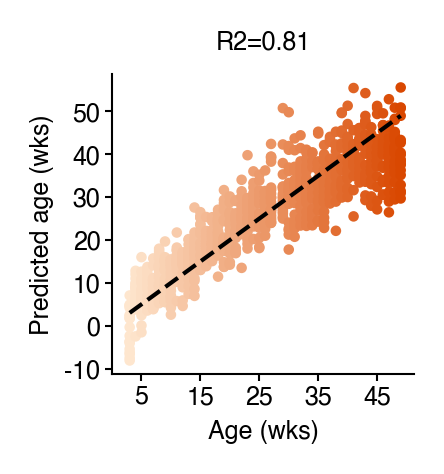

In [12]:
fig = figure(1.3, 1.3)
ax = fig.gca()
plt.scatter(y_age, y_pred, c=y_age, cmap=cmf, s=3)
#add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None),yticks=[-10,0, 10, 20, 30, 40,50,60], xticks=[5, 15, 25, 35, 45], xlabel="Age (wks)", ylabel="Predicted age (wks)", 
       title=f"R2={r2_age:0.2f}",
      )
plt.plot(y_age, y_age, linestyle='--', color='black')
sns.despine()

In [13]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_longv2_female.pdf', bbox_inches='tight')

In [14]:
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv, n_jobs=-1)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [40:39<00:00, 24.39s/it]


/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


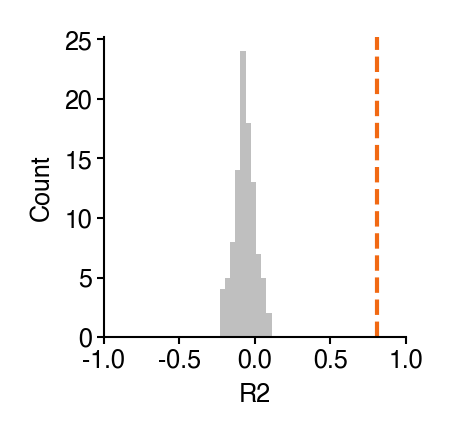

In [15]:
fig = plt.figure(figsize=(1.3, 1.3))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='black', alpha=0.25)
ax.axvline(r2_age, color='#f16913', lw=1, linestyle='--')

ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_shuf_longv2_female.pdf', bbox_inches='tight')

In [16]:
## leave one age out

In [17]:
# Prepare data
data = f_df.copy()

# Extract features and target
X = data.to_numpy()
y = data.index.get_level_values('age').to_numpy()
groups = data.index.get_level_values('age').to_numpy()

cv = LeaveOneGroupOut()
cv.get_n_splits(X, y, groups)

# decoder
y_age=y
y_pred = cross_val_predict(clf, X, y_age, groups=groups, cv=cv, n_jobs=-1)
r2_age = r2_score(y_age, y_pred)

In [18]:
from scipy.stats import pearsonr
print(pearsonr(y_age, np.array(y_pred).flatten()))

PearsonRResult(statistic=0.8907947063922342, pvalue=5.927183537999218e-301)


In [19]:
# Calculating Mean Absolute Error (MAE)
mae_age = median_absolute_error(y_age, y_pred)
print("Median Absolute Error (MAE):", mae_age)

Median Absolute Error (MAE): 4.031323197563809


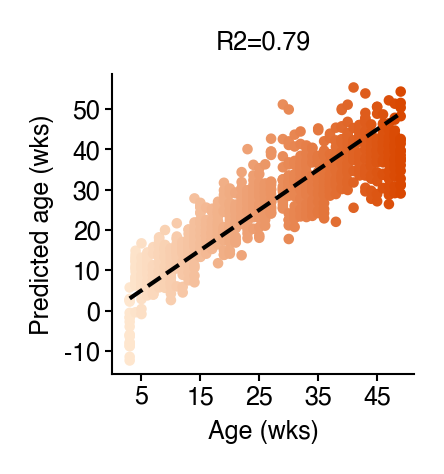

In [20]:
fig = figure(1.3, 1.3)
ax = fig.gca()
plt.scatter(y_age, y_pred, c=y_age, cmap=cmf, s=3)
#add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None),yticks=[-10,0, 10, 20, 30, 40,50,60], xticks=[5, 15, 25, 35, 45], xlabel="Age (wks)", ylabel="Predicted age (wks)", 
       title=f"R2={r2_age:0.2f}",
      )
plt.plot(y_age, y_age, linestyle='--', color='black')
sns.despine()

In [21]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_leave_age_out_longv2_female.pdf', bbox_inches='tight')

In [22]:
## shuffle
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, groups=groups, cv=cv, n_jobs=-1)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:12<00:00,  1.93s/it]


/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


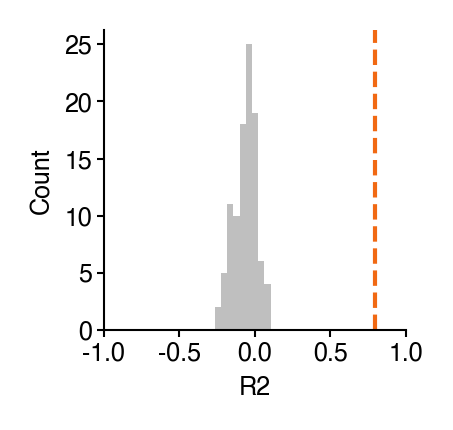

In [23]:
fig = plt.figure(figsize=(1.3, 1.3))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='black', alpha=0.25)
ax.axvline(r2_age, color='#f16913', lw=1, linestyle='--')

ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_shuf_longv2_female_age_out.pdf', bbox_inches='tight')